<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modelling

In [1]:
#!pip install tensorflow
#!pip install chart_studio
#!pip install pmdarima --user

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

# Basic packages
from datetime import datetime, timedelta # manipulating date formats
import seaborn as sns # for prettier plots

# # TIME SERIES
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

from tqdm import tqdm
import tensorflow as tf
import random

plt.style.use('bmh')

## Import Data

In [3]:
train_final = pd.read_csv('../dataset/train_final.csv',
                          parse_dates=['date'],
                          infer_datetime_format=True,
                          )

In [4]:
test_final = pd.read_csv('../dataset/test_final.csv',
                          parse_dates=['date'],
                          infer_datetime_format=True,
                          index_col=0
                          )

## ARIMA

In [5]:
all_sales = train_final.groupby('date').agg({"sales" : "mean"}).reset_index()
all_sales.set_index('date',inplace=True)
all_sales.index.freq = 'D'

In [6]:
y_train, y_val = train_test_split(all_sales, test_size=.2, shuffle=False)

In [7]:
y_train.shape, y_val.shape

((1350, 1), (338, 1))

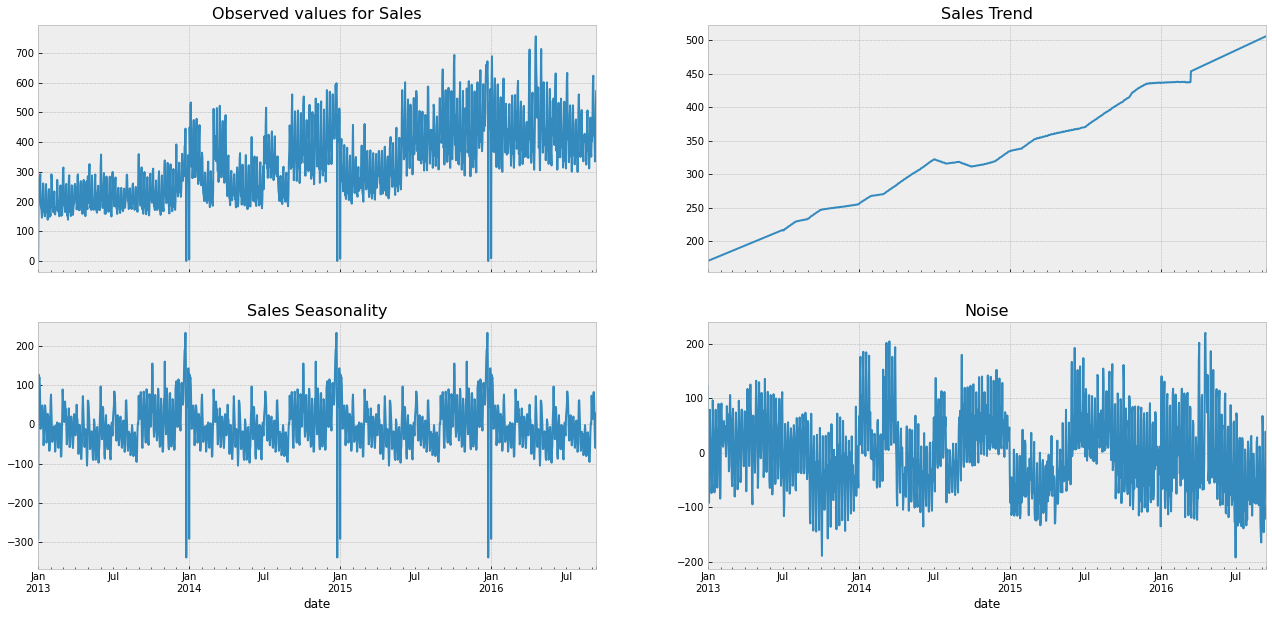

In [8]:
decomp = seasonal_decompose(y_train,period=365,model='additive',extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, )

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, )

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, )

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, );

In [9]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
# Aggregating the Time Series to a monthly scaled index
y = y_train[['sales']]
y = y.resample('1D').mean()
        
adf_test(y['sales'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.543258
p-value                    0.105301
# lags used               22.000000
# observations          1327.000000
critical value (1%)       -3.435287
critical value (5%)       -2.863720
critical value (10%)      -2.567931
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [11]:
# Aggregating the Time Series to a monthly scaled index
y = y_train[['sales']]
y = y.resample('1D').mean()
        
adf_test(y['sales'].diff(),title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.689692e+00
p-value                 4.072269e-14
# lags used             2.100000e+01
# observations          1.327000e+03
critical value (1%)    -3.435287e+00
critical value (5%)    -2.863720e+00
critical value (10%)   -2.567931e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


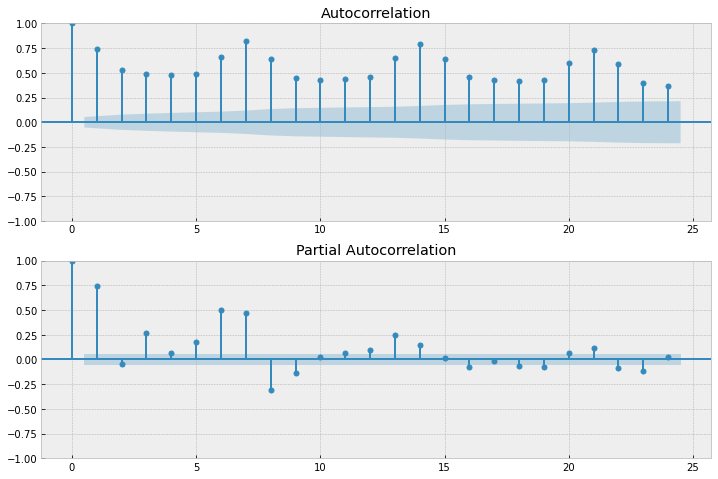

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(y_train['sales'].dropna(), lags = 24, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(y_train['sales'].dropna(), lags = 24, method = 'ywm', ax=ax2)

plt.show()

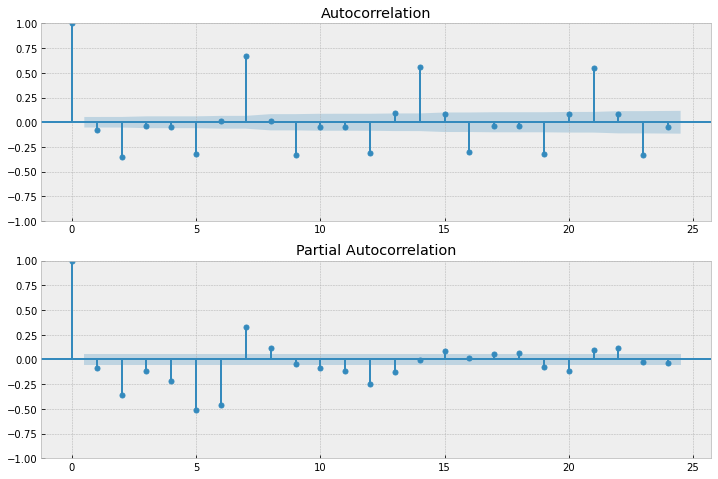

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# Generate autocorrelation plot on training data.
plot_acf(y_train['sales'].diff().dropna(), lags = 24, ax=ax1);
# Generate partial autocorrelation plot on training data.
plot_pacf(y_train['sales'].diff().dropna(), lags = 24, method = 'ywm',ax=ax2);
plt.show()

In [14]:
auto_arima(all_sales,trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19499.906, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20210.100, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20184.867, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19894.034, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20208.112, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19557.965, Time=1.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19532.439, Time=1.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19511.504, Time=2.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19197.193, Time=3.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19560.179, Time=1.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19348.671, Time=3.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=19398.871, Time=3.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=19516.852, Time=2.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=19148.379, Time=3.93 sec
 ARIMA(4,1,4)(0,0,0

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
a_model =  ARIMA(y_train, order = (5,1,5))
preds = a_model.fit()
preds.summary()

C:\Users\CAdministrator\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1350
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -7291.638
Date:                Thu, 08 Sep 2022   AIC                          14605.277
Time:                        04:09:18   BIC                          14662.555
Sample:                    01-01-2013   HQIC                         14626.728
                         - 09-11-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1883      0.039     30.437      0.000       1.112       1.265
ar.L2         -1.7455      0.032    -54.461      0.000      -1.808      -1.683
ar.L3          1.3444      0.055     24.500      0.000       1.237       1.452
ar.L4         -1.2901      0.031    -41.887      0.000      -1.350      -1.230
ar.L5          0.3803      0.037     10.355      0.000       0.308       0.452
ma.L1         -1.6914      0.030    -56.836      0.000      -1.750      -1.633
ma.L2          2.0815      0.037     56.058      0.000       2.009       2.154
ma.L3         -1.9312      0.044    -43.828      0.000      -2.018      -1.845
ma.L4          1.5177      0.033     46.662      0.000       1.454       1.581
ma.L5         -0.7970      0.021    -38.674      0.000      -0.837      -0.757
sigma2      3925.1106    106.823     36.744      0.000    3715.741    4134.480
===================================================================================
Ljung-Box (L1) (Q):                   4.89   Jarque-Bera (JB):             28753.43
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
predicte_results = preds.predict(start = len(y_train), end = len(y_train)+len(y_val) -1,typ= 'levels')
predicte_results

2016-09-12    457.306387
2016-09-13    412.312113
2016-09-14    412.273209
2016-09-15    376.326160
2016-09-16    405.239809
                 ...    
2017-08-11    440.031880
2017-08-12    476.063763
2017-08-13    481.634263
2017-08-14    450.305146
2017-08-15    420.652992
Freq: D, Name: predicted_mean, Length: 338, dtype: float64

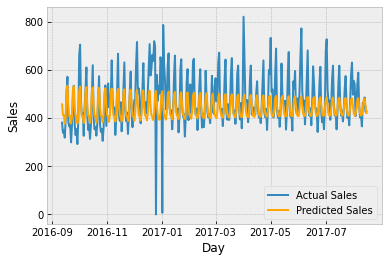

In [17]:
plt.plot(y_val, label = 'Actual Sales')
plt.plot(predicte_results, color = 'orange', label = 'Predicted Sales')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [18]:
import math
rmsle = math.sqrt(mean_squared_log_error(y_val,predicte_results))
rmsle

0.4402190986424186

<b>Findings:</b> Able to forcast the overall daily result, having hard time forcasting by stores and product family.

## SARIMAX

In [19]:
train_final = pd.read_csv('../dataset/train_final.csv',
                          parse_dates=['date'],
                          infer_datetime_format=True,
                         )

In [20]:
train_final.head(3)

,date,store_nbr,family,sales,onpromotion,year,month,week,weekday,city,state,store_type,cluster,holiday_type,locale,transferred,dcoilwtico,transactions,isholiday
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,2013,1,1,Tuesday,Quito,Pichincha,D,13,Holiday,National,False,93.14,0.0,1
1,2013-01-01,1.0,BABY CARE,0.0,0.0,2013,1,1,Tuesday,Quito,Pichincha,D,13,Holiday,National,False,93.14,0.0,1
2,2013-01-01,1.0,BEAUTY,0.0,0.0,2013,1,1,Tuesday,Quito,Pichincha,D,13,Holiday,National,False,93.14,0.0,1


In [21]:
train_final[(train_final.date == '2013-01-01') & (train_final.sales > 0)][['date','sales']].groupby('date').sum()

,sales
date,
2013-01-01,2511.618999


In [22]:
all_sales = train_final.groupby('date').agg({"sales" : "mean","onpromotion" : "mean","isholiday":"mean"}).reset_index()
all_sales.set_index('date',inplace=True)
all_sales.index.freq = 'D'

Using onpromotion and isholiday as eXo features for forcasting.

In [23]:
all_sales

,sales,onpromotion,isholiday
date,,,
2013-01-01,1.409438,0.000000,1.000000
2013-01-02,278.390807,0.000000,0.000000
2013-01-03,202.840197,0.000000,0.000000
2013-01-04,198.911154,0.000000,0.000000
2013-01-05,267.873244,0.000000,0.000000
...,...,...,...
2017-08-11,463.733851,7.956790,1.000000
2017-08-12,444.798280,4.664422,0.000000
2017-08-13,485.768618,5.209315,0.000000


In [24]:
y_train, y_val = train_test_split(all_sales, test_size=.2, shuffle=False)

In [25]:
y_train.shape, y_val.shape

((1350, 3), (338, 3))

In [26]:
exo = all_sales.iloc[:,1:3]
exo_train =  y_train.iloc[:,1:3]
exo_val = y_val.iloc[:,1:3]

In [27]:
exo.shape,exo_train.shape,exo_val.shape

((1688, 2), (1350, 2), (338, 2))

In [28]:
auto_arima(all_sales['sales'],trace = True, D= 1, m =7,exogenous = exo)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=19356.458, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=18806.434, Time=1.37 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=18645.411, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=19354.718, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=19077.611, Time=0.53 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=18548.673, Time=4.07 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=18853.140, Time=2.04 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=5.02 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=4.84 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=8.72 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=18564.840, Time=1.3

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 1, 2, 7),
      suppress_warnings=True)

In [29]:
b_model =  SARIMAX(y_train['sales'], exog = exo_train, order = (0,0,1), seasonal_order = (0,1,2,7))

In [30]:
b_model_preds = b_model.fit()

C:\Users\CAdministrator\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
predicte_results = b_model_preds.predict(start = len(y_train), end = len(y_train)+len(y_val) -1,exog = exo_val,typ= 'levels')
predicte_results

2016-09-12    432.908254
2016-09-13    391.504958
2016-09-14    401.637953
2016-09-15    390.698938
2016-09-16    452.575099
                 ...    
2017-08-11    490.725055
2017-08-12    540.157843
2017-08-13    582.532234
2017-08-14    464.983475
2017-08-15    444.060910
Freq: D, Name: predicted_mean, Length: 338, dtype: float64

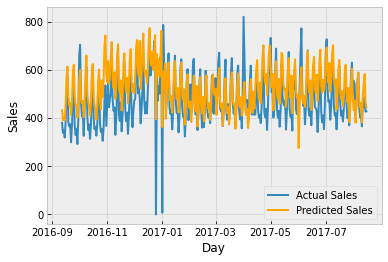

In [32]:
plt.plot(y_val['sales'], label = 'Actual Sales')
plt.plot(predicte_results, color = 'orange', label = 'Predicted Sales')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [33]:
import math
rmsle = math.sqrt(mean_squared_log_error(y_val['sales'],predicte_results))
rmsle

0.42546473679901453

<b>Findings:</b> The result is better then ARIMA with the seasonality feature but also same as ARIMA, it is a having hard time forcasting by stores and product family.

## LSTM

In [34]:
def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
    return round(metric, 4)

In [35]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [36]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
        
    plt.xlabel('Days')

    
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                      sequence_stride=1, shuffle=True, batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


def compile_and_fit(model, window, MAX_EPOCHS=20, learning_rate=0.2, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

In [37]:
train_set =  pd.read_csv('../dataset/train.csv',
                          parse_dates=['date'],
                          infer_datetime_format=True
                         )
test_set = pd.read_csv('../dataset/test.csv',
                          parse_dates=['date'],
                          infer_datetime_format=True,
                         )

In [38]:
# Parameters settings
start_training_ds = '2017-01-01'
input_width = 7
label_width = 16

MAX_EPOCHS = 100
learning_rate = 0.001
scaling = ['standardisation', 'normalisation'][0]

# Prepare the dataframe
train_df = train_set
test_df = test_set

# Reshape the dataframe
df = train_df[train_df.date >= start_training_ds].assign(
    key=train_df['store_nbr'].astype('str') + '~' + train_df['family'])
df = pd.pivot_table(df, values = 'sales', index=['date'], columns='key').reset_index()
date_time = df.date
df = df.drop('date', axis=1)
df = df.iloc[:, :df.shape[1]]
column_indices = {name: i for i, name in enumerate(df.columns)}


# Split into train, val and test set
n = len(df)
test_df = df[-label_width:]
val_df = df[-(input_width + 2*label_width):-label_width]
train_df = df[:-(input_width + label_width)]

print("Train set size: (%s, %s)" %(train_df.shape[0], train_df.shape[1]))
print("Validation set size: (%s, %s)"  %(test_df.shape[0], test_df.shape[1]))
print("Test set size: (%s, %s) \n"  %(val_df.shape[0], val_df.shape[1]))

num_features = df.shape[1]

# Perform normalisation
if scaling == 'standardisation':
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    train_df = train_df.fillna(0)
    val_df = (val_df - train_mean) / train_std
    val_df = val_df.fillna(0)
    test_df = (test_df - train_mean) / train_std
    test_df = test_df.fillna(0)

    train_df[train_df == np.inf] = 0
    val_df[val_df == np.inf] = 0
    test_df[test_df == np.inf] = 0

elif scaling == 'normalisation':
    scaler = MinMaxScaler(feature_range=(0,1))
    train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
    val_df = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
    test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.make_dataset = make_dataset
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot

# Generate windows for training batches
window = WindowGenerator(input_width=input_width, label_width=label_width, shift=label_width,
                         train_df=train_df, val_df=val_df, test_df=test_df)

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.Conv1D(filters=128, kernel_size=(input_width,), activation='relu'),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(label_width*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([label_width, num_features])
])

print('Input shape:', window.example[0].shape)
print('Labels shape:', window.example[1].shape)
print('Output shape:', model(window.example[0]).shape)

history = compile_and_fit(model, window, MAX_EPOCHS, learning_rate)

Train set size: (204, 1782)
Validation set size: (16, 1782)
Test set size: (23, 1782) 

Input shape: (32, 7, 1782)
Labels shape: (32, 16, 1782)
Output shape: (32, 16, 1782)
Epoch 1/100
6/6 [==============================] - 4s 209ms/step - loss: 0.9134 - mean_absolute_error: 0.6966 - val_loss: 1.8144 - val_mean_absolute_error: 0.7005
Epoch 2/100
6/6 [==============================] - 1s 99ms/step - loss: 0.8549 - mean_absolute_error: 0.6682 - val_loss: 1.7201 - val_mean_absolute_error: 0.6549
Epoch 3/100
6/6 [==============================] - 1s 98ms/step - loss: 0.7674 - mean_absolute_error: 0.6238 - val_loss: 1.6591 - val_mean_absolute_error: 0.6244
Epoch 4/100
6/6 [==============================] - 1s 100ms/step - loss: 0.7196 - mean_absolute_error: 0.5991 - val_loss: 1.6476 - val_mean_absolute_error: 0.6201
Epoch 5/100
6/6 [==============================] - 1s 108ms/step - loss: 0.6940 - mean_absolute_error: 0.5849 - val_loss: 1.6330 - val_mean_absolute_error: 0.6114
Epoch 6/100
6/

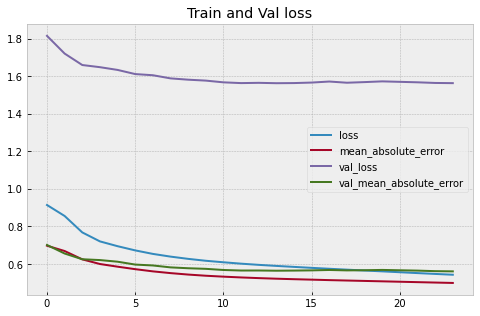

In [39]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('Train and Val loss')
plt.show()

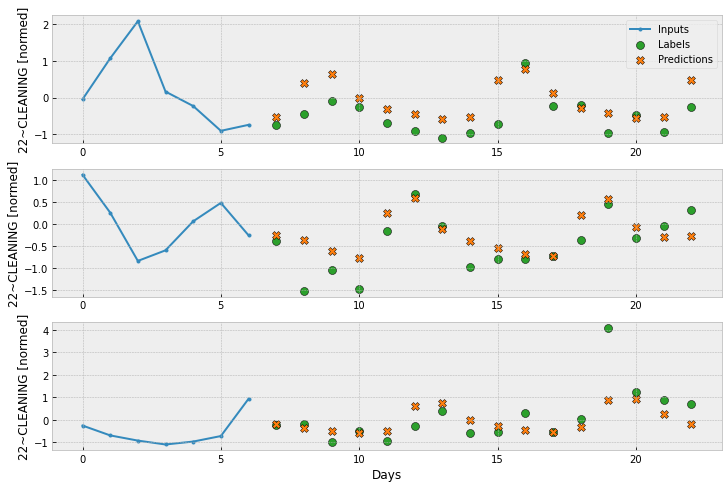

In [40]:
window.plot(model, plot_col=random.choice(train_df.columns))

In [41]:
# Generate predictions for the test period taking the last values of the validation period
y_hat = model.predict(val_df.values[-input_width:, :].reshape(1, input_width, num_features))
#inversed standardized
predict_df = (pd.DataFrame(y_hat.reshape(label_width, num_features), columns=df.columns)*train_std + train_mean).assign(date=date_time[-label_width:].values)
columns_to_keep = [e for e in predict_df.columns if '~' in e or e == 'date'] 
predict_df = predict_df[columns_to_keep]
predict_df = predict_df.melt(id_vars =['date'], value_vars =[c for c in predict_df.columns if c != 'date'])
predict_df[['store_nbr', 'family']] = predict_df.key.str.split('~', expand=True)
predict_df = predict_df.rename(columns={'value': 'y_hat'})
predict_df['store_nbr'] = predict_df.store_nbr.astype('int')
predict_df.drop('key', axis=1, inplace=True)

predict_df = pd.merge(train_set.drop('id', axis=1), predict_df, on=['date', 'store_nbr', 'family'], how='left')
predict_df['y_hat'] = np.clip(predict_df.y_hat, 0, np.inf)

predict_df.tail(20)

1/1 [==============================] - 1s 523ms/step


,date,store_nbr,family,sales,onpromotion,y_hat
3000868,2017-08-15,9,GROCERY II,9.000,0,14.345047
3000869,2017-08-15,9,HARDWARE,1.000,0,1.207133
3000870,2017-08-15,9,HOME AND KITCHEN I,64.000,0,41.547889
3000871,2017-08-15,9,HOME AND KITCHEN II,61.000,2,37.662404
3000872,2017-08-15,9,HOME APPLIANCES,0.000,0,0.290975
3000873,2017-08-15,9,HOME CARE,373.000,6,419.356737
3000874,2017-08-15,9,LADIESWEAR,10.000,0,15.107718
3000875,2017-08-15,9,LAWN AND GARDEN,11.000,3,9.044757
3000876,2017-08-15,9,LINGERIE,6.000,0,8.219104
3000877,2017-08-15,9,"LIQUOR,WINE,BEER",25.000,2,29.273886


In [42]:
predict_df['error'] = (np.log(1 + predict_df[~predict_df.y_hat.isnull()].sales) - np.log(1 + predict_df[~predict_df.y_hat.isnull()].y_hat))**2
print("RMSLE: %s" %rmsle(predict_df[~predict_df.y_hat.isnull()].sales, predict_df[~predict_df.y_hat.isnull()].y_hat))

RMSLE: 0.564


In [43]:
predict_df['key'] = predict_df['store_nbr'].astype(str) + '~' + predict_df['family'].astype(str)
rmsle_per_ts_df = predict_df.groupby('key').agg({'error': 'sum'}).sort_values('error', ascending=False).reset_index()
rmsle_per_ts_df.head(10)

,key,error
0,45~SCHOOL AND OFFICE SUPPLIES,294.986344
1,47~SCHOOL AND OFFICE SUPPLIES,262.724881
2,48~SCHOOL AND OFFICE SUPPLIES,254.808446
3,50~SCHOOL AND OFFICE SUPPLIES,248.340219
4,49~SCHOOL AND OFFICE SUPPLIES,233.558863
5,46~SCHOOL AND OFFICE SUPPLIES,232.810152
6,44~SCHOOL AND OFFICE SUPPLIES,208.512336
7,9~SCHOOL AND OFFICE SUPPLIES,195.337542
8,36~SCHOOL AND OFFICE SUPPLIES,139.943144
9,40~SCHOOL AND OFFICE SUPPLIES,126.101350


<b>Findings :</b> The top 10 errors came seem to from the school and office supplies product family.

In [44]:
y_hat = model.predict(df.values[-input_width:, :].reshape(1, input_width, num_features))
#inversed standardized
predict_dff = (pd.DataFrame(y_hat.reshape(label_width, num_features),
                            columns=df.columns)*train_std + train_mean).assign(date=pd.date_range(
    date_time.iloc[-1] + timedelta(days=1), date_time.iloc[-1] + timedelta(days=label_width)))

predict_dff = predict_dff.melt(id_vars =['date'], value_vars =[c for c in predict_dff.columns if c != 'date'])
predict_dff[['store_nbr', 'family']] = predict_dff.key.str.split('~', expand=True)
predict_dff = predict_dff.rename(columns={'value': 'y_hat'})
predict_dff['store_nbr'] = predict_dff.store_nbr.astype('int')
predict_dff.drop('key', axis=1, inplace=True)

predict_dff = pd.merge(test_set, predict_dff,  on=['date', 'store_nbr', 'family'], how='left')
predict_dff['y_hat'] = np.clip(predict_dff.y_hat, 0, np.inf)

#predict_dff[['id', 'y_hat']].rename(columns={'y_hat': 'sales'}).to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 25ms/step


In [45]:
investigate = train_set[train_set.family == 'SCHOOL AND OFFICE SUPPLIES'].groupby('date').mean().sales

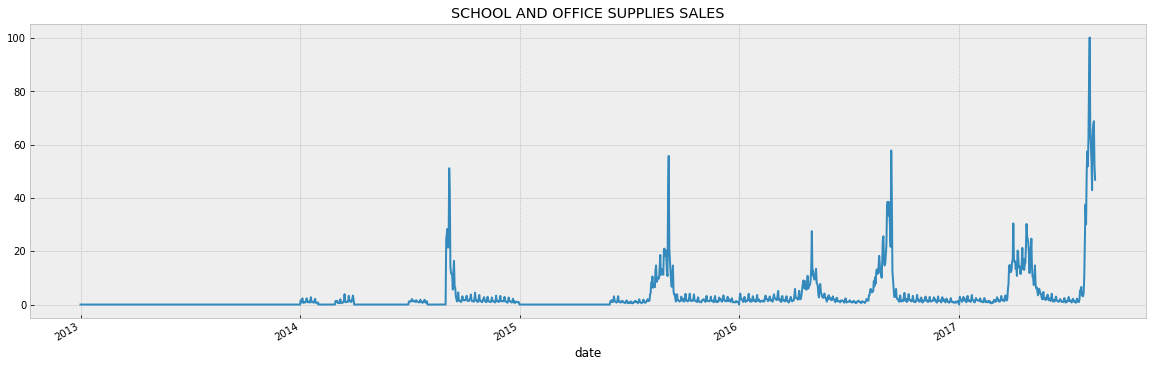

In [46]:
investigate.plot(figsize = (20,6), title = 'SCHOOL AND OFFICE SUPPLIES SALES');

<b>Findings :</b> The school and office supplies product family seems to have big surge during aug-sept period and in 2017 the sales surge was much higher, thus the LSTM model still did not manage to learn it well.

# Kaggle Submission Scoring

<img src="../image/kaggle Score 0_585.JPG" style="float: left; margin: 20px; height: 150px">

# Conclusion

- The best results are taken from Univariate LSTM (with rolling window of 1 year)
- The SARIMA model outperformed the LSTM for the long term prediction task, but has it limitation to run by stores and product families.
- LSTM model was more robust, although RMSLE wasnt very good for Long window period but it did quite well if the window for 1 year.

- Might be further consider XGBoost or LGBM or FB Prophet for further ML forecasting